# Tutorial Step 4: Working in the frequency domain

Working in the time domain is often not convenient so it's important to be familiar with the frequency domain.
The [frequency domain](https://en.wikipedia.org/wiki/Frequency_domain) is a representation of time-series which represents how the signal is distributed within different frequency bands over a range of frequencies (so called the "spectrum" of a signal).
Working in the frequency domain is more convenient for common operations such as filtering or signal identification.
It's possible to transform a signal into the frequency domain and vice-versa.

Before going further, let's go back to our previous example (there is nothing new in the code below):

In [1]:
#----------------------
# Import needed modules
#----------------------
import numpy as np
import matplotlib.pylab as plt
import matplotlib.mlab as mlab
import h5py

#----------
# Open file
#----------
fileName = 'H-H1_GWOSC_O3b_4KHZ_R1-1264312320-4096.hdf5'
dataFile = h5py.File(fileName, 'r')

#-------------------------------------
# Read the strain and some information
#-------------------------------------
strain   = dataFile['strain']['Strain']
ts       = dataFile['strain']['Strain'].attrs['Xspacing']
meta     = dataFile['meta']
gpsStart = meta['GPSstart'][()]
duration = meta['Duration'][()]
gpsEnd   = gpsStart + duration
time     = np.arange(gpsStart, gpsEnd, ts)

#-----------------------------
# Extract a part of the signal
#-----------------------------
length     = 16     # Length in second
startTime  = 1264316116.0
numsamples = int(length / ts)
startIndex = np.min(np.nonzero(startTime < time))
time_seg   = time[startIndex:(startIndex+numsamples)]
strain_seg = strain[startIndex:(startIndex+numsamples)]

An important concept when working in frequency domain, is the notion of [sampling frequency](https://en.wikipedia.org/wiki/Sampling_(signal_processing)).
This is simply the inverse of the time between 2 samples.
We will store this in a variable called `fs`.

In [2]:
# Sampling frequency
fs = int(1.0 / ts)

## FFT with Blackman Window

A Fast Fourier Transform, or FFT, is one method to transform the data into the frequency domain.
Here, we first apply a Blackman Window to force the data to zero at the time boundaries, and so reduce edge effects in the FFT.
The noise spectrum of current instruments is seen to have the most power at low frequencies ($f < 50 Hz$), due mainly to seismic noise.
The most sensitive band, often called "The Bucket", is roughly 100 - 300 Hz.

Text(0, 0.5, 'Strain / Hz')

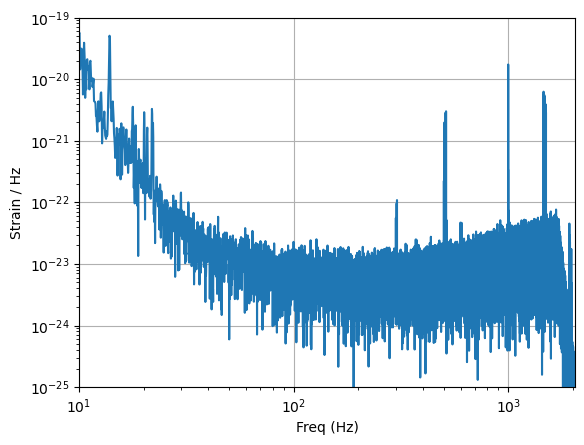

In [3]:
#------------------------------------------
# Apply a Blackman Window, and plot the FFT
#------------------------------------------
window          = np.blackman(strain_seg.size)
windowed_strain = strain_seg * window
freq_domain     = np.fft.rfft(windowed_strain) / fs
freq            = np.fft.rfftfreq(len(windowed_strain)) * fs    
plt.loglog(freq, abs(freq_domain))
plt.axis([10, fs/2.0, 1e-25, 1e-19])
plt.grid('on')
plt.xlabel('Freq (Hz)')
plt.ylabel('Strain / Hz')

## Power Spectral Density (PSD) and Amplitude Spectral Density (ASD)

The Power Spectral Density is another representation of how the power in the data is distributed in frequency space.
Matplotlib's [`psd`](https://matplotlib.org/stable/api/mlab_api.html#matplotlib.mlab.psd) method uses Welch's method to estimate the PSD.
The method divides the data into segments with `NFFT` samples, computes a periodogram of each segment (similar to the FFT plotted above), and then takes the time average of the periodograms.
This averaging over several segments reduces the variance in the result, which is why the PSD looks "thinner" than the FFT.

Text(0, 0.5, 'PSD')

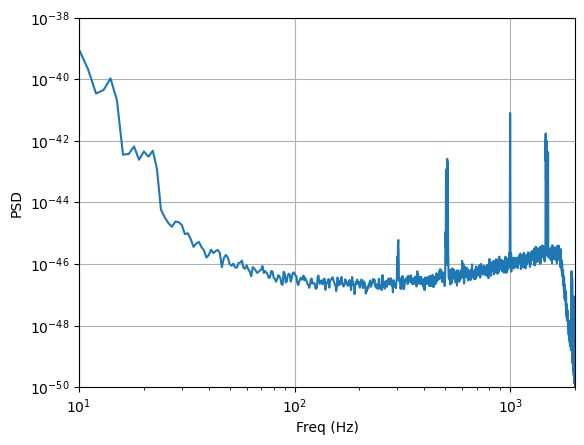

In [4]:
#-----------
# Make a PSD
#-----------
Pxx, freqs = mlab.psd(strain_seg, Fs=fs, NFFT=fs)
plt.loglog(freqs, Pxx)
plt.axis([10, 2000, 1e-50, 1e-38])
plt.grid('on')
plt.xlabel('Freq (Hz)')
plt.ylabel('PSD')

A variation is to use the square root of the PSD.
This is is called the Amplitude Spectral Density (ASD) and is done to give units that can be more easily compared with the time domain data or FFT.
More information about the ASD of the instruments can be seen on the page of each dataset, generally in a section called "Instrumental Spectral Lines" (see [here](https://gwosc.org/O3/o3speclines/) for O3b).

Text(0, 0.5, 'ASD (Strain / Hz$^{1/2})$')

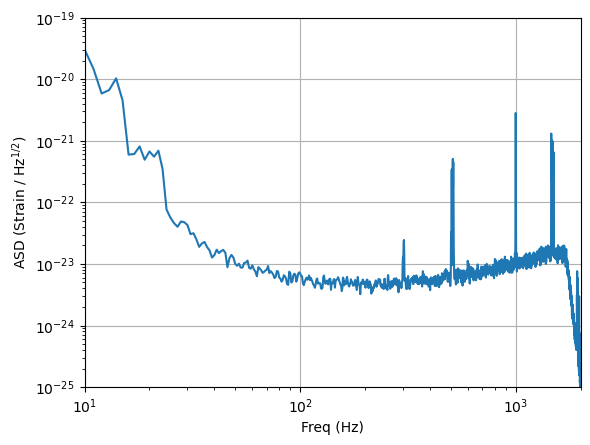

In [5]:
#-------------
# Plot the ASD
#-------------
plt.loglog(freqs, np.sqrt(Pxx))
plt.axis([10, 2000, 1e-25, 1e-19])
plt.grid('on')
plt.xlabel('Freq (Hz)')
plt.ylabel('ASD (Strain / Hz$^{1/2})$')

## Spectrogram & normalized spectrogram

Working in the frequency domain is important but we loose all notion of when an event can occur.
Intuitively, we would like to study how the distribution of frequency varies across time.
Spectrograms are a way to show this.

Text(0, 0.5, 'Freq (Hz)')

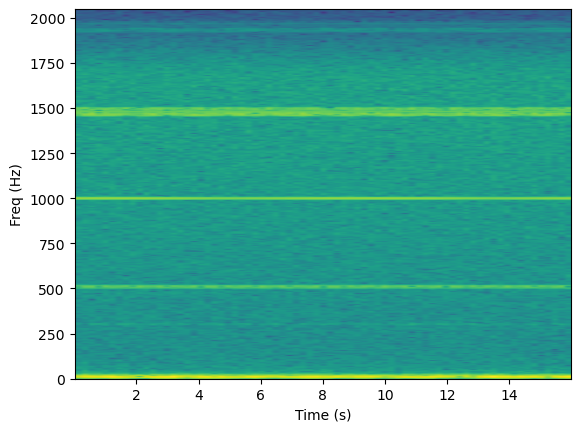

In [6]:
#-------------------
# Make a spectrogram
#-------------------
NFFT = 1024
short_window = np.blackman(NFFT)
spec_power, freqs, bins, im = plt.specgram(
    strain_seg, NFFT=NFFT, Fs=fs,
    window=short_window
)
plt.xlabel('Time (s)')
plt.ylabel('Freq (Hz)')

Mainly, this spectrogram shows what we already knew from the PSD: there is a lot more power at very low frequencies than high frequencies.
If we are looking for time variation in the data, it can be helpful to normalize each frequency bin by the typical power at that frequency.
We can do this, and then re-plot the spectrogram, using Matplotlib's `colormesh` function.

Text(0, 0.5, 'Freq (Hz)')

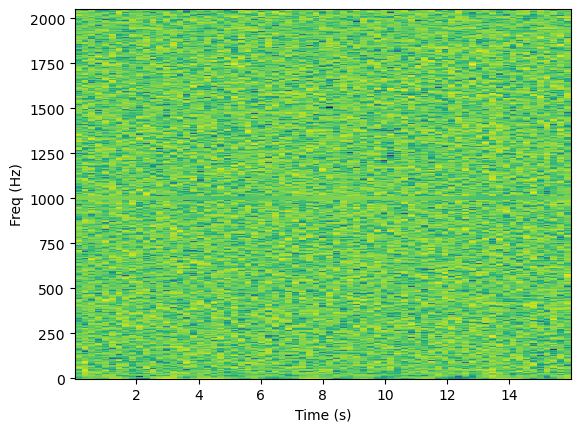

In [7]:
#------------------------------
# Plot renormalized spectrogram
#------------------------------
med_power = np.zeros(freqs.shape)
norm_spec_power = np.zeros(spec_power.shape)
index = 0
for row in spec_power:
    med_power[index] = np.median(row)
    norm_spec_power[index] = row / med_power[index]
    index += 1
plt.pcolormesh(bins, freqs, np.log10(norm_spec_power))
plt.xlabel('Time (s)')
plt.ylabel('Freq (Hz)')

## What's next?

In the [next step](<05 - GWOSC API Examples.ipynb>), you will learn to use a python package to ease interaction with GWOSC data.